In [13]:
import os
import numpy as np
from scipy.optimize import linear_sum_assignment
from transformers import AutoTokenizer,EsmForMaskedLM
import torch
import requests
from Bio import SeqIO
from io import StringIO
import gzip
import pickle
import random
from Star_positions import star_positions
from chemo_recep_dict import dict_chemo, dict_recep
from itertools import combinations
import networkx as nx
import plotly.graph_objects as go
from ipywidgets import interact, widgets, fixed
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap

Lpath = "../../data/Ligands_uniprot_fasta/"
Rpath = "../../data/Receptors_uniprot_fasta/"





# Loading the model:

In [2]:
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
model = EsmForMaskedLM.from_pretrained("facebook/esm2_t6_8M_UR50D")

In [3]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)
model = model.to(device)

mps


In [4]:
def download_fasta(list_ids, output_file):
    
    for id in list_ids:
        output = output_file + f"{id}.fasta"
        url = f"https://rest.uniprot.org/uniprotkb/stream?query=accession:({id})&format=fasta"
        response = requests.get(url)
    
        if response.status_code == 200:

            with open(output, "w") as file:
                file.write(response.text)
            print(f"FASTA sequences saved to {output}")
        else:
            print(f"Failed to fetch data. HTTP Status: {response.status_code}")
            print(response.text)



# Preparing the chemokines

In [5]:
chemo_info_dict = {}
Ligands_fasta = os.listdir(Lpath)

for ffile in Ligands_fasta:
    if ffile.endswith(".DS_Store"):
        pass
    else:
        ffile_path = Lpath + ffile
        for record in SeqIO.parse(ffile_path, "fasta"):
            uniprot = ffile.replace(".fasta", "")
            Gene_ID = dict_chemo[uniprot]
            #if "OS=Homo sapiens" in record.description or "OX=9606" in record.description:
            chemo_info_dict[Gene_ID] = str(record.seq)
print(chemo_info_dict)




{'CXCL16': 'MGRDLRPGSRVLLLLLLLLLVYLTQPGNGNEGSVTGSCYCGKRISSDSPPSVQFMNRLRKHLRAYHRCLYYTRFQLLSWSVCGGNKDPWVQELMSCLDLKECGHAYSGIVAHQKHLLPTSPPISQASEGASSDIHTPAQMLLSTLQSTQRPTLPVGSLSSDKELTRPNETTIHTAGHSLAAGPEAGENQKQPEKNAGPTARTSATVPVLCLLAIIFILTAALSYVLCKRRRGQSPQSSPDLPVHYIPVAPDSNT', 'CXCL4': 'MSSAAGFCASRPGLLFLGLLLLPLVVAFASAEAEEDGDLQCLCVKTTSQVRPRHITSLEVIKAGPHCPTAQLIATLKNGRKICLDLQAPLYKKIIKKLLES', 'CXCL9': 'MKKSGVLFLLGIILLVLIGVQGTPVVRKGRCSCISTNQGTIHLQSLKDLKQFAPSPSCEKIEIIATLKNGVQTCLNPDSADVKELIKKWEKQVSQKKKQKNGKKHQKKKVLKVRKSQRSRQKKTT', 'CXCL11': 'MSVKGMAIALAVILCATVVQGFPMFKRGRCLCIGPGVKAVKVADIEKASIMYPSNNCDKIEVIITLKENKGQRCLNPKSKQARLIIKKVERKNF', 'CXCL1': 'MARAALSAAPSNPRLLRVALLLLLLVAAGRRAAGASVATELRCQCLQTLQGIHPKNIQSVNVKSPGPHCAQTEVIATLKNGRKACLNPASPIVKKIIEKMLNSDKSN', 'CCL7': 'MKASAALLCLLLTAAAFSPQGLAQPVGINTSTTCCYRFINKKIPKQRLESYRRTTSSHCPREAVIFKTKLDKEICADPTQKWVQDFMKHLDKKTQTPKL', 'CCL26': 'MMGLSLASAVLLASLLSLHLGTATRGSDISKTCCFQYSHKPLPWTWVRSYEFTSNSCSQRAVIFTTKRGKKVCTHPRKKWVQKYISLLKTPKQL', 'CCL11': 'MKVSAALLWLLLIAAAFSPQGLA

In [6]:
def download_fasta(list_ids, output_file):
    
    for id in list_ids:
        output = output_file + f"{id}.fasta"
        url = f"https://rest.uniprot.org/uniprotkb/stream?query=accession:({id})&format=fasta"
        response = requests.get(url)
    
        if response.status_code == 200:

            with open(output, "w") as file:
                file.write(response.text)
            print(f"FASTA sequences saved to {output}")
        else:
            print(f"Failed to fetch data. HTTP Status: {response.status_code}")
            print(response.text)




#download_fasta(dict_recep.values(),)


In [ ]:
recep_info_dict = {}
Receptors_fasta = os.listdir(Rpath)

for ffile in Receptors_fasta:
    if ffile.endswith(".DS_Store"):
        pass
    else:
        ffile_path = Rpath + ffile
        for record in SeqIO.parse(ffile_path, "fasta"):
            uniprot = ffile.replace(".fasta", "")
            Gene_ID = dict_recep[uniprot]
            #if "OS=Homo sapiens" in record.description or "OX=9606" in record.description:
            recep_info_dict[Gene_ID] = str(record.seq)
print(recep_info_dict)
        

In [ ]:

pairs= [(R,C) for R in recep_info_dict for C in chemo_info_dict]
print(pairs)


In [ ]:
def compute_mlm_loss(pair_list, recep_dict, chemo_dict, iterations=5):
    loss_dict = {}
    for pair in pair_list:
        total_loss = 0.0
        connector= "G" * 25
    
        for _ in range(iterations):
            protein = recep_dict[pair[0]]
            binder = chemo_dict[pair[1]]
            # Concatenate protein sequences with a separator
            concatenated_sequence = protein + connector + binder
            inputs = tokenizer(concatenated_sequence, return_tensors="pt", padding=True, truncation=True, max_length=1024)

            
            mask_prob = 0.55  # For instance, masking 25% of the sequence
            mask_indices = torch.rand(inputs["input_ids"].shape, device=device) < mask_prob
            

            # Locate the position of the connector "G" and set their mask to false.
            connector_indices = tokenizer.encode(connector, add_special_tokens=False)
            connector_length = len(connector_indices)
            start_connector = len(tokenizer.encode(protein, add_special_tokens=False))
            end_connector = start_connector + connector_length

            mask_indices[0, start_connector:end_connector] = False
        

            inputs["input_ids"][mask_indices] = tokenizer.mask_token_id
            inputs = {k: v.to(device) for k, v in inputs.items()}

            # Compute the MLM loss
            with torch.no_grad():
              outputs = model(**inputs, labels=inputs["input_ids"])

            loss = outputs.loss
            total_loss += loss.item()

        # Return the average loss
        avg_loss = total_loss / iterations
        loss_dict[pair]= avg_loss
    return loss_dict

      
        


pair_loss_dict = compute_mlm_loss(pairs, recep_info_dict, chemo_info_dict)
print(pair_loss_dict)



In [ ]:
# creating a graph of connections

max_threshold = max(pair_loss_dict.values())
def plot_graph(threshold, pair_loss_dict= pair_loss_dict, chemo_dict = dict_chemo, recep_dict=dict_recep, recep_info_dict = recep_info_dict, chemo_info_dict = chemo_info_dict):
    G = nx.Graph()
    for R in recep_dict.values():
        G.add_node(R, type= "Receptor", sequence= recep_info_dict[R], color='blue')

    for C in chemo_dict.values():
        G.add_node(C, type= "Chemokine", sequence= chemo_info_dict[C], color='red')

    for pair in pair_loss_dict:
        rec_gene = pair[0]
        ch_gene= pair[1]
        avg_loss= pair_loss_dict[pair]
        if avg_loss > threshold:
            G.add_edge(rec_gene, ch_gene, weight= round(avg_loss, 3))

    k_value = 10
    pos = nx.spring_layout(G, dim=3, seed=42, k=k_value)

    edge_x= []
    edge_y = []
    edge_z = []

    for edge in G.edges():
        x0, y0, z0 = pos[edge[0]]
        x1, y1, z1 = pos[edge[1]]

        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
        edge_z.extend([z0, z1, None])

    edge_trace = go.Scatter3d(x=edge_x, y=edge_y, z=edge_z, mode='lines', line=dict(width=2, color='grey'))

    node_x = []
    node_y = []
    node_z =[]
    node_color = []

    node_text = []
    for node, attributes in G.nodes(data = True):
        x, y, z = pos[node]
        node_x.append(x)
        node_y.append(y)
        node_z.append(z)
        node_text.append(f"{node} ({attributes['type']})")
        node_color.append(attributes['color'])  # Add the node's color attribute



    node_trace = go.Scatter3d(x = node_x, y = node_y, z = node_z, mode = 'markers', marker=dict(size=12, color=node_color), hoverinfo='text', hovertext=node_text)
    layout = go.Layout(
        title='Protein Interaction Graph', 
        title_x=0.5, 
        scene=dict(
            xaxis=dict(showbackground=False), yaxis=dict(showbackground=False), 
            zaxis=dict(showbackground=False), camera=dict(eye=dict(x=0.5, y=0.5, z=0.5)),  
            aspectmode="auto"), margin=dict(t=0, b=0, l=0, r=0))
    fig = go.Figure(data=[edge_trace, node_trace], layout=layout)
    fig.show()



interact(
    plot_graph,
    threshold=widgets.FloatSlider(min=0.0, max=max_threshold, step=0.05, value=8.5),
    pair_loss_dict=fixed(pair_loss_dict),
    chemo_dict=fixed(dict_chemo),
    recep_dict=fixed(dict_recep),
    recep_info_dict=fixed(recep_info_dict),
    chemo_info_dict=fixed(chemo_info_dict),
)
#plot_graph(6)

    


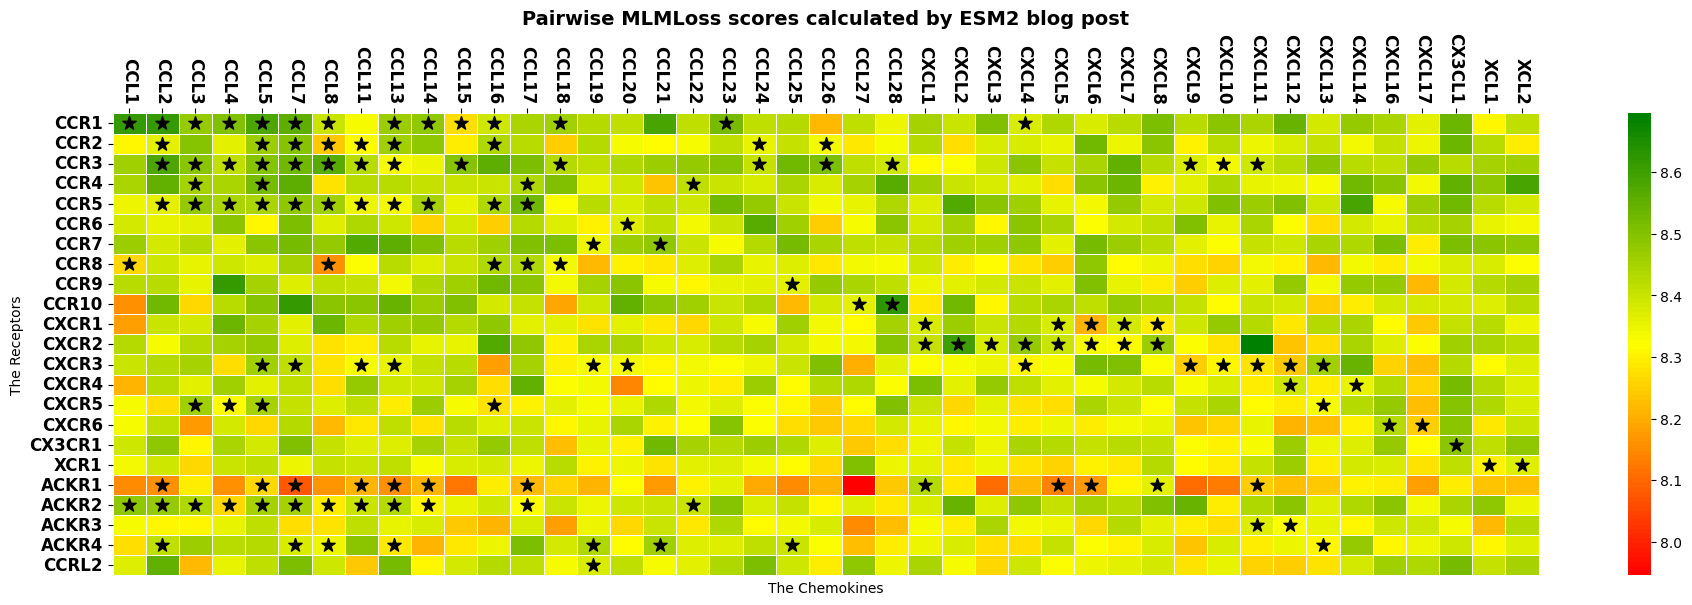

In [14]:
def heat_map(pair_loss_dict, dict_recep, dict_chemo, star_positions= star_positions):

    mat = np.zeros((len(dict_recep.values()), len(dict_chemo.values())))
    for i, r in enumerate(dict_recep.values()):
        for j, c in enumerate(dict_chemo.values()):
            mat[i, j] = pair_loss_dict[r, c]
    heatmap_df = pd.DataFrame(mat, index= dict_recep.values(), columns=dict_chemo.values())
    plt.figure(figsize=(23, 6))
    colors = ["red", "yellow", "green"]
    n_bins = 100 
    cmap = LinearSegmentedColormap.from_list("red_yellow_green", colors, N=n_bins)
    sns.heatmap(heatmap_df, annot=False, cmap=cmap, fmt=".2f", linewidths=0.5)
    for row, col in star_positions:
        row = row + 0.5
        col = col + 0.5
        plt.scatter(col, row,s = 100, marker = '*', color = "black")
    plt.yticks(fontsize=12, fontweight="bold") 
    plt.gca().xaxis.set_ticks_position('top')
    plt.gca().tick_params(axis='x', bottom=False, top=True)
    plt.xticks(rotation=-90, fontsize=12, fontweight="bold")
    plt.title('Pairwise MLMLoss scores calculated by ESM2 blog post',fontsize=14, fontweight="bold")
    plt.xlabel("The Chemokines")
    plt.ylabel("The Receptors")
    plt.show()

    

heat_map(pair_loss_dict, dict_recep, dict_chemo)



        